In [1]:
import numpy as np
# Importing Pandas Library 
import pandas as pd
import matplotlib.pyplot as plt
from preprocessing import *
import os
import joblib
from sklearn.preprocessing import MinMaxScaler
from utils import *

import tensorflow as tf
import keras
from tensorflow.keras.models import Model, load_model

from models.EEGNet import *

from sklearn.metrics import confusion_matrix

from preprocessing import *

In [2]:
@keras.saving.register_keras_serializable(package="my_package", name="UpdatedIoU")
class UpdatedIoU(tf.keras.metrics.IoU):
  def __init__(self,
        num_classes,
        target_class_ids,
        name=None,
        dtype=None,
        ignore_class=None,
        sparse_y_true=True,
        sparse_y_pred=True,
        axis=-1
    ):
    super(UpdatedIoU, self).__init__(
        num_classes=num_classes,
        target_class_ids=target_class_ids,
        name=name,
        dtype=dtype,
        ignore_class=ignore_class,
        sparse_y_true=sparse_y_true,
        sparse_y_pred=sparse_y_pred,
        axis=axis
    )

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
model = load_model(r'./checkpoints/orthogonal_standard_64_timesteps_trainable_True_dang.keras')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ eyebrows input      │ (None, 4, 64, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ left input          │ (None, 4, 64, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right input         │ (None, 4, 64, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ both input          │ (None, 4, 64, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teeth input         │ (None, 4, 64, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eyebrows            │ (None, 256)       │    102,400 │ eyebrows          │
│ (Functional)        │                   │            │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ left (Functional)   │ (None, 256)       │     63,488 │ left input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right (Functional)  │ (None, 256)       │    102,400 │ right input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ both (Functional)   │ (None, 256)       │    102,400 │ both input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teeth (Functional)  │ (None, 256)       │    102,400 │ teeth input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1280)      │          0 │ eyebrows[0][0],   │
│ (Concatenate)       │                   │            │ left[0][0],       │
│                     │                   │            │ right[0][0],      │
│                     │                   │            │ both[0][0],       │
│                     │                   │            │ teeth[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  1,311,744 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 384)       │    196,992 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 64, 6)     │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax             │ (None, 64, 6)     │          0 │ reshape[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,502,978 (28.62 MB)

 Trainable params: 2,498,176 (9.53 MB)

 Non-trainable params: 8,448 (33.00 KB)

 Optimizer params: 4,996,354 (19.06 MB)

In [5]:
from tensorflow.keras.utils import plot_model

In [6]:
plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [7]:
df_eyebrows = pd.read_csv(r'./data/inference_data/eyebrows.csv').drop(columns=['timestamps', 'Right AUX'])
df_left = pd.read_csv(r'./data/inference_data/left.csv').drop(columns=['timestamps', 'Right AUX'])
df_right = pd.read_csv(r'./data/inference_data/right.csv').drop(columns=['timestamps', 'Right AUX'])
df_both = pd.read_csv(r'./data/inference_data/both.csv').drop(columns=['timestamps', 'Right AUX'])
df_teeth = pd.read_csv(r'./data/inference_data/teeth.csv').drop(columns=['timestamps', 'Right AUX'])

In [8]:
label_name = ['eyebrows', 'left', 'right', 'both', 'teeth']
scalers = {}
for label in label_name:
    scalers[label] = joblib.load(rf'./pipeline_{label}/checkpoints/scaler_standard.save')

In [9]:
filters = {
    'left': filter_left,
    'right': filter_right,
    'both': filter_both,
    'teeth': filter_teeth,
    'eyebrows': filter_eyebrows,
}

In [10]:
def get_input(df, time_step = 128):
    data = df.to_numpy()
    input_data = []
    
    for i in range(0, data.shape[0] // time_step * time_step, time_step):
        x_eyebrows = pipeline(data, filters['eyebrows'], scalers['eyebrows'], i, time_step)
        x_left = pipeline(data, filters['left'], scalers['left'], i, time_step)
        x_right = pipeline(data, filters['right'], scalers['right'], i, time_step)
        x_both = pipeline(data, filters['both'], scalers['both'], i, time_step)
        x_teeth = pipeline(data, filters['teeth'], scalers['teeth'], i, time_step)
        input_data.append(
            np.concatenate(
                [
                    x_eyebrows,
                    x_left,
                    x_right,
                    x_both,
                    x_teeth
                ],
                axis=1
            )
        )

    input_data = np.array(input_data)
    input_data = input_data[:, :, :, np.newaxis]
    input_data = input_data.transpose(0, 2, 1, 3)
    print(input_data.shape)
    
    return data, np.array(input_data)

In [11]:
def get_output(input_data):
    y_pred = model.predict([
        input_data[:, :4], 
        input_data[:, 4:8], 
        input_data[:, 8:12],
        input_data[:, 12:16],
        input_data[:, 16:20]
    ])
    y_pred = np.concatenate(y_pred, axis=0)
    y_pred_onehot = y_pred

    return y_pred_onehot

In [12]:
def plot_data_result(data, y_pred_onehot, title):
    plt.figure(figsize=(50, 30)).suptitle(title, fontsize=40)
    plt.subplot(9, 1, 1)
    plt.title("TP9", fontsize=40)
    plt.plot(data[:, 0])
    plt.subplot(9, 1, 2)
    plt.title("AF7", fontsize=40)
    plt.plot(data[:, 1])
    plt.subplot(9, 1, 3)
    plt.title("AF8", fontsize=40)
    plt.plot(data[:, 2])
    plt.subplot(9, 1, 4)
    plt.title("TP10", fontsize=40)
    plt.plot(data[:, 3])
    plt.subplot(9, 1, 5)
    plt.title("Result eyebrows", fontsize=40)
    plt.plot(y_pred_onehot[:, 1])
    plt.subplot(9, 1, 6)
    plt.title("Result left", fontsize=40)
    plt.plot(y_pred_onehot[:, 2])
    plt.subplot(9, 1, 7)
    plt.title("Result right", fontsize=40)
    plt.plot(y_pred_onehot[:, 3])
    plt.subplot(9, 1, 8)
    plt.title("Result both", fontsize=40)
    plt.plot(y_pred_onehot[:, 4])
    plt.subplot(9, 1, 9)
    plt.title("Result teeth", fontsize=40)
    plt.plot(y_pred_onehot[:, 5])

(140, 20, 64, 1)
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


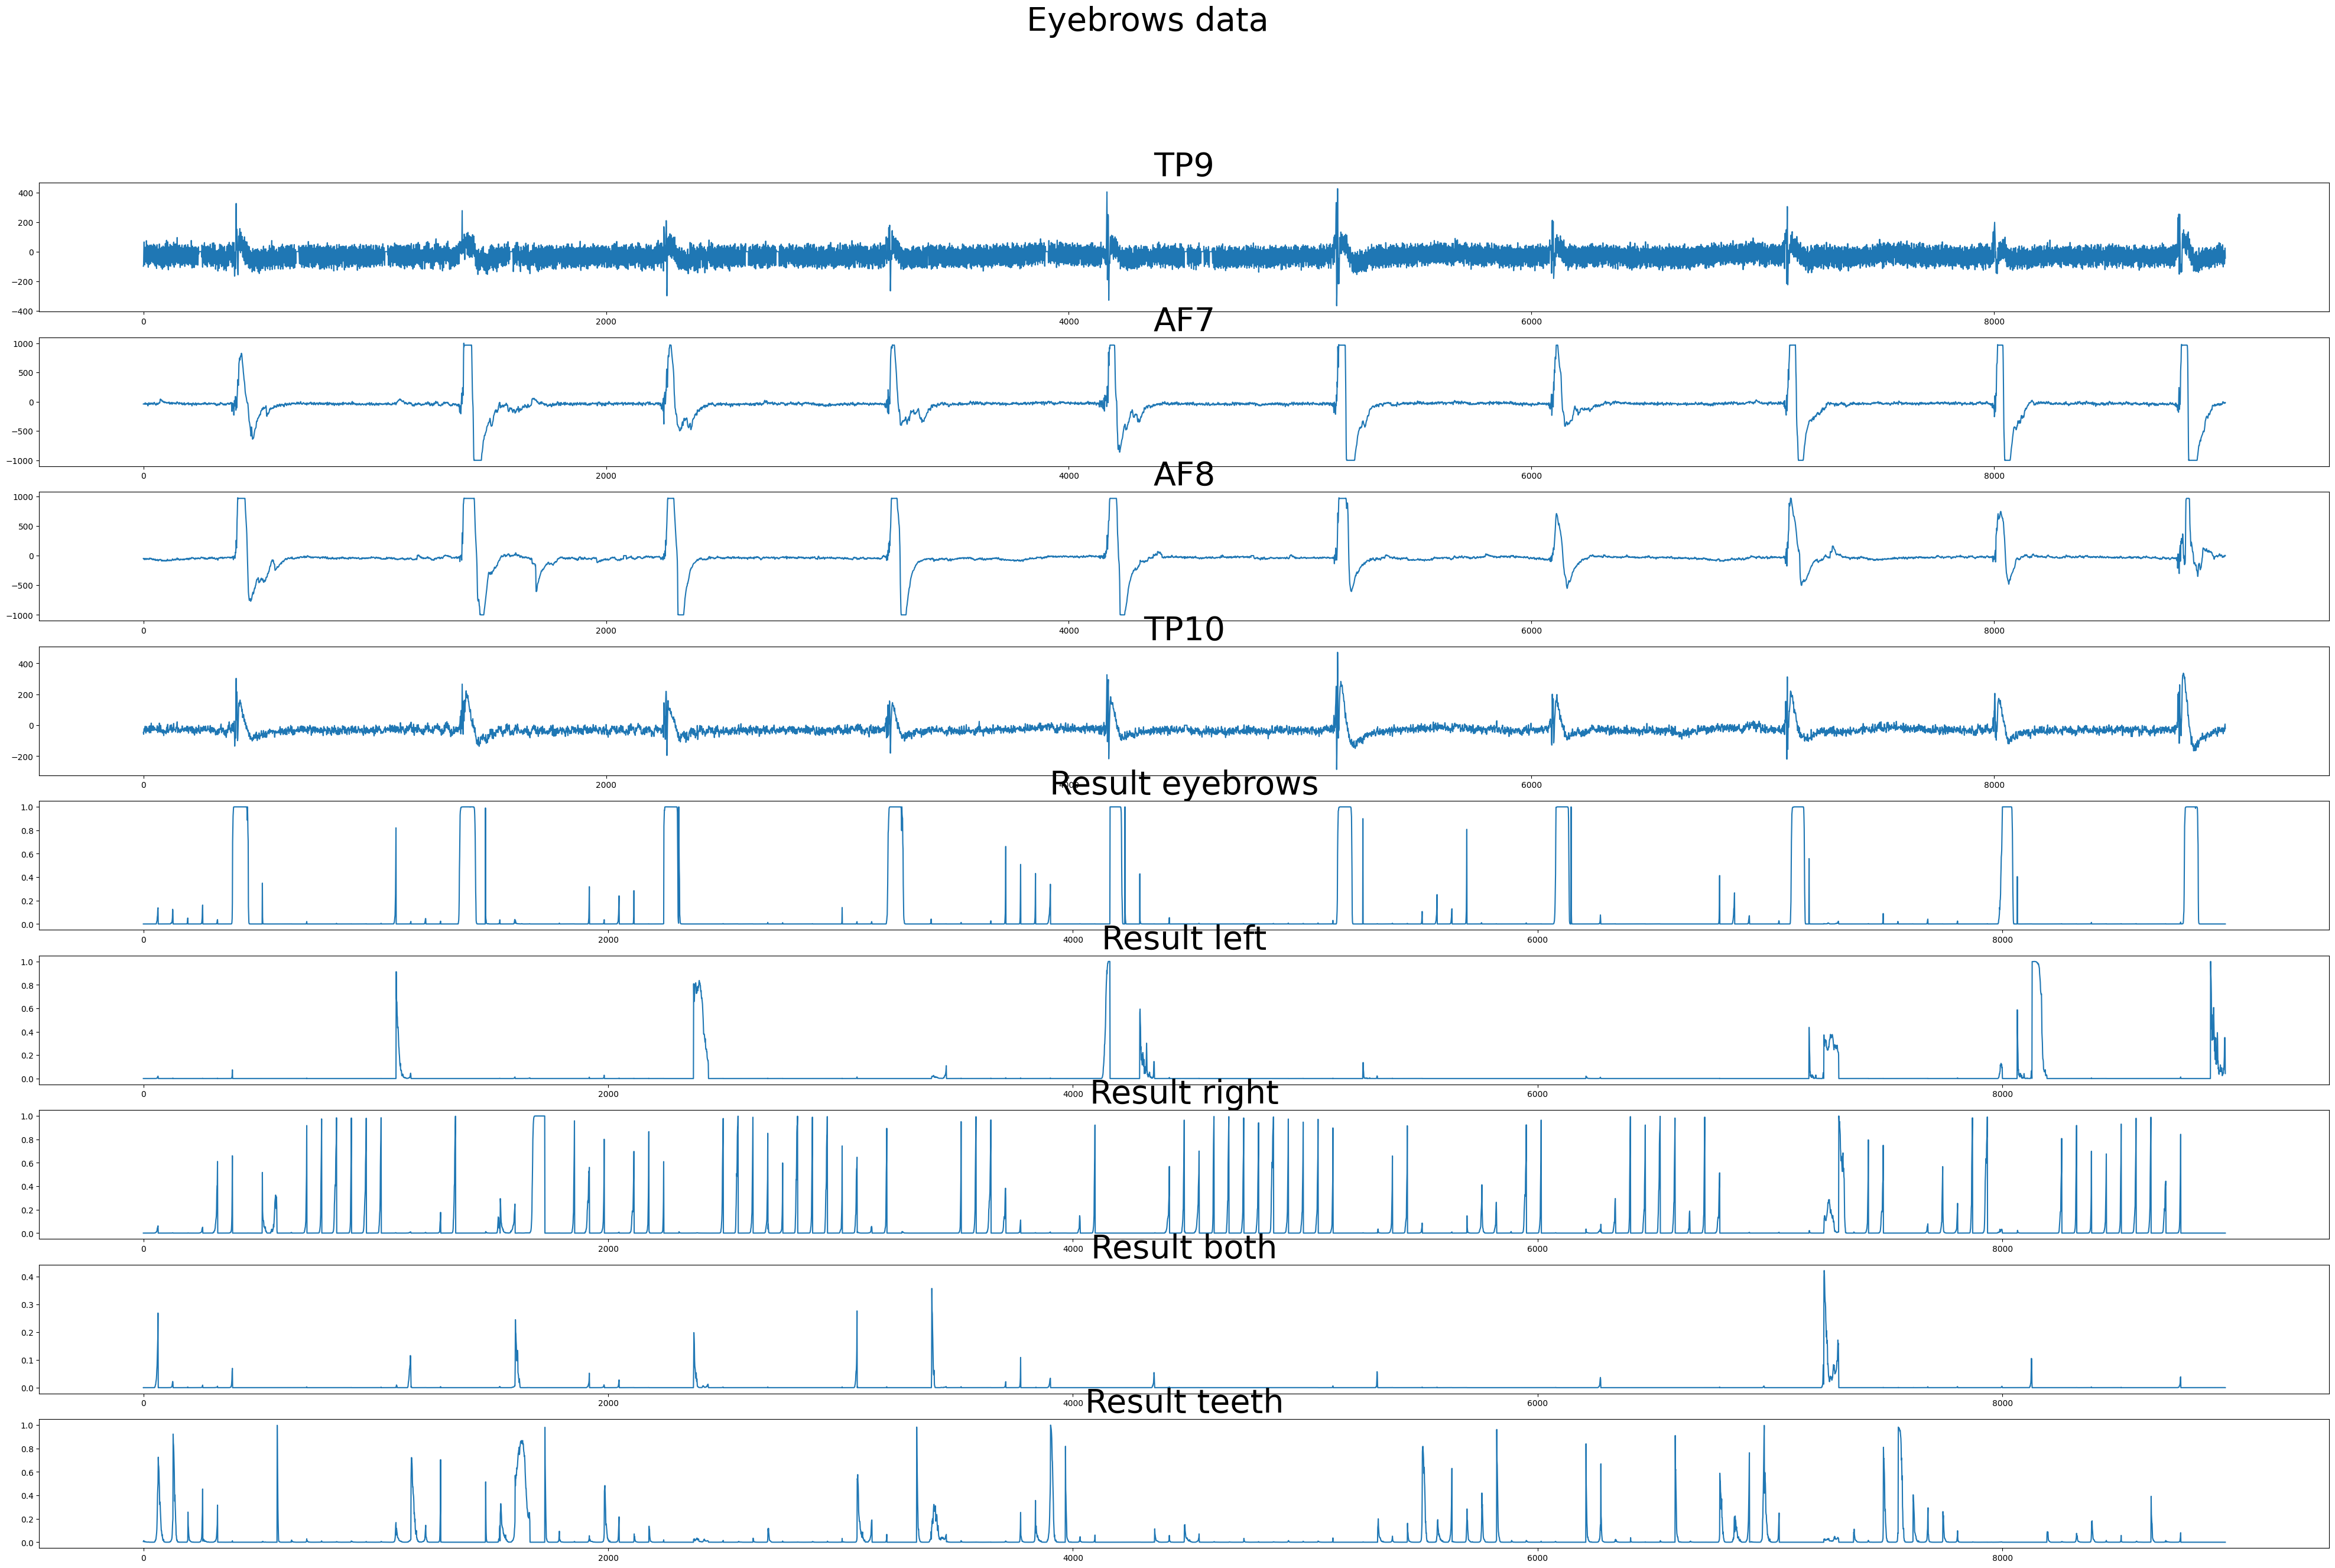

In [13]:
data, input_data = get_input(df_eyebrows, time_step=64)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Eyebrows data")

(140, 20, 64, 1)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


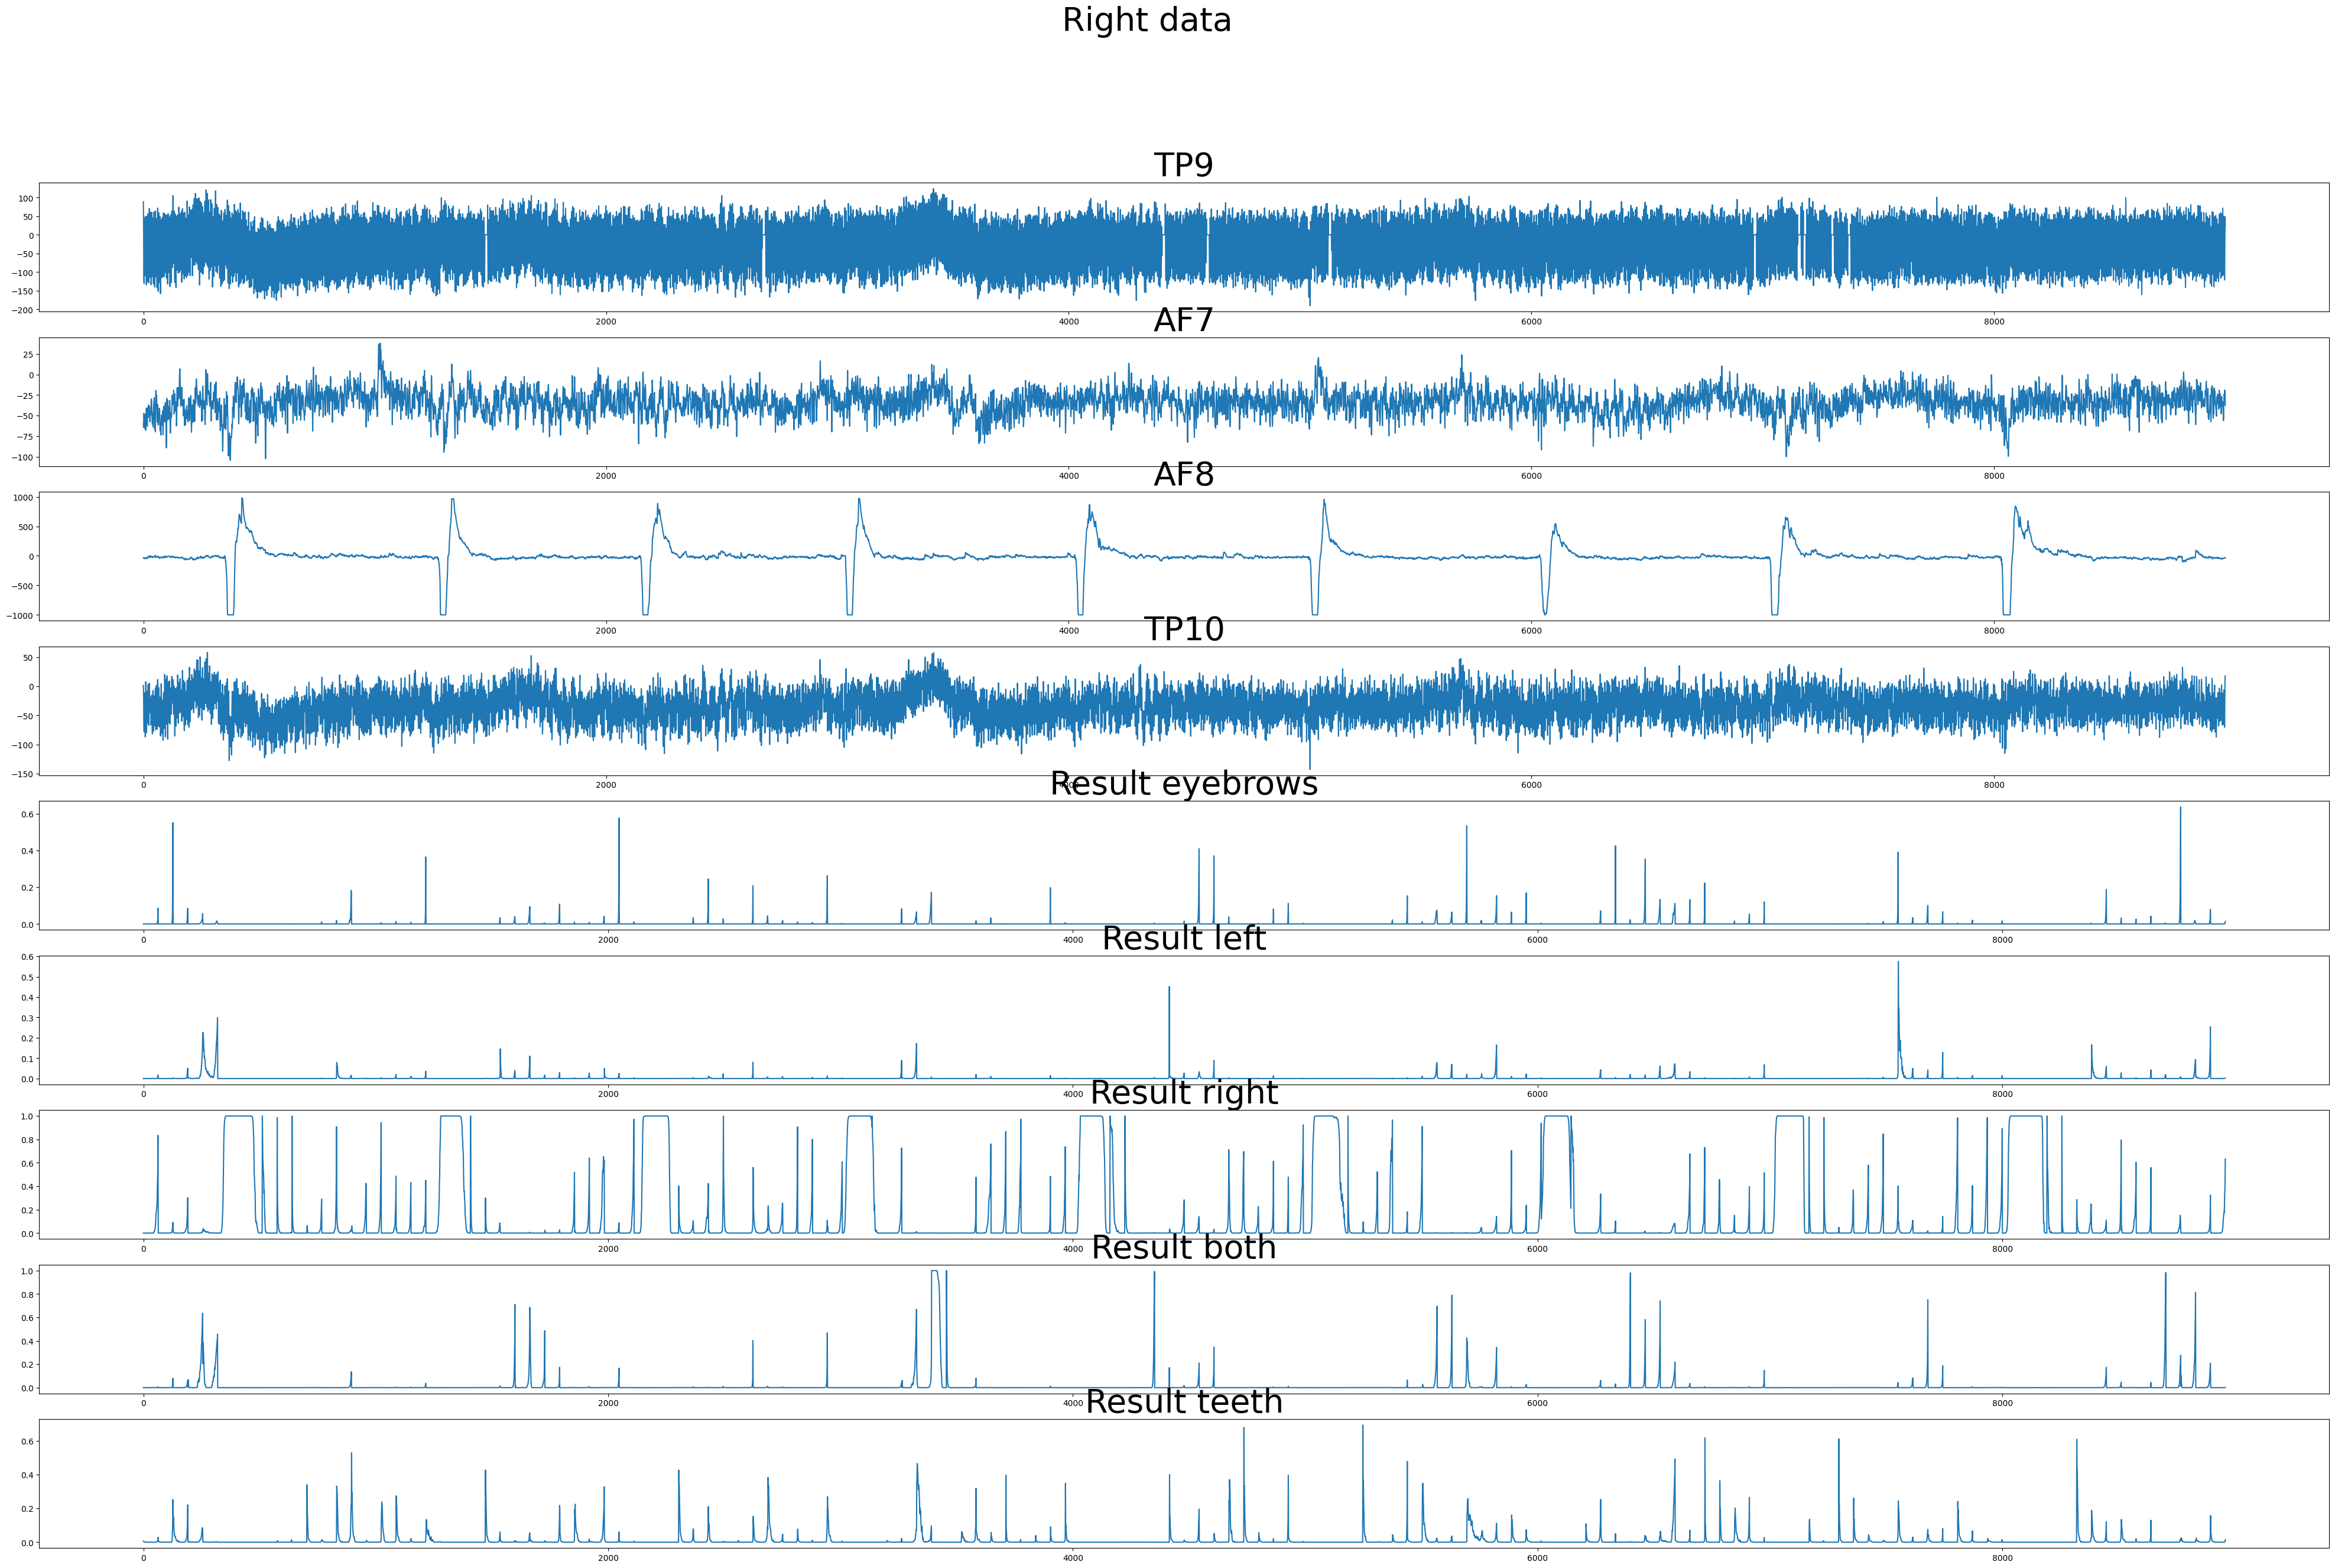

In [14]:
# Eyebrows inference dataset
data, input_data = get_input(df_right, time_step=64)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Right data")

(140, 20, 64, 1)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


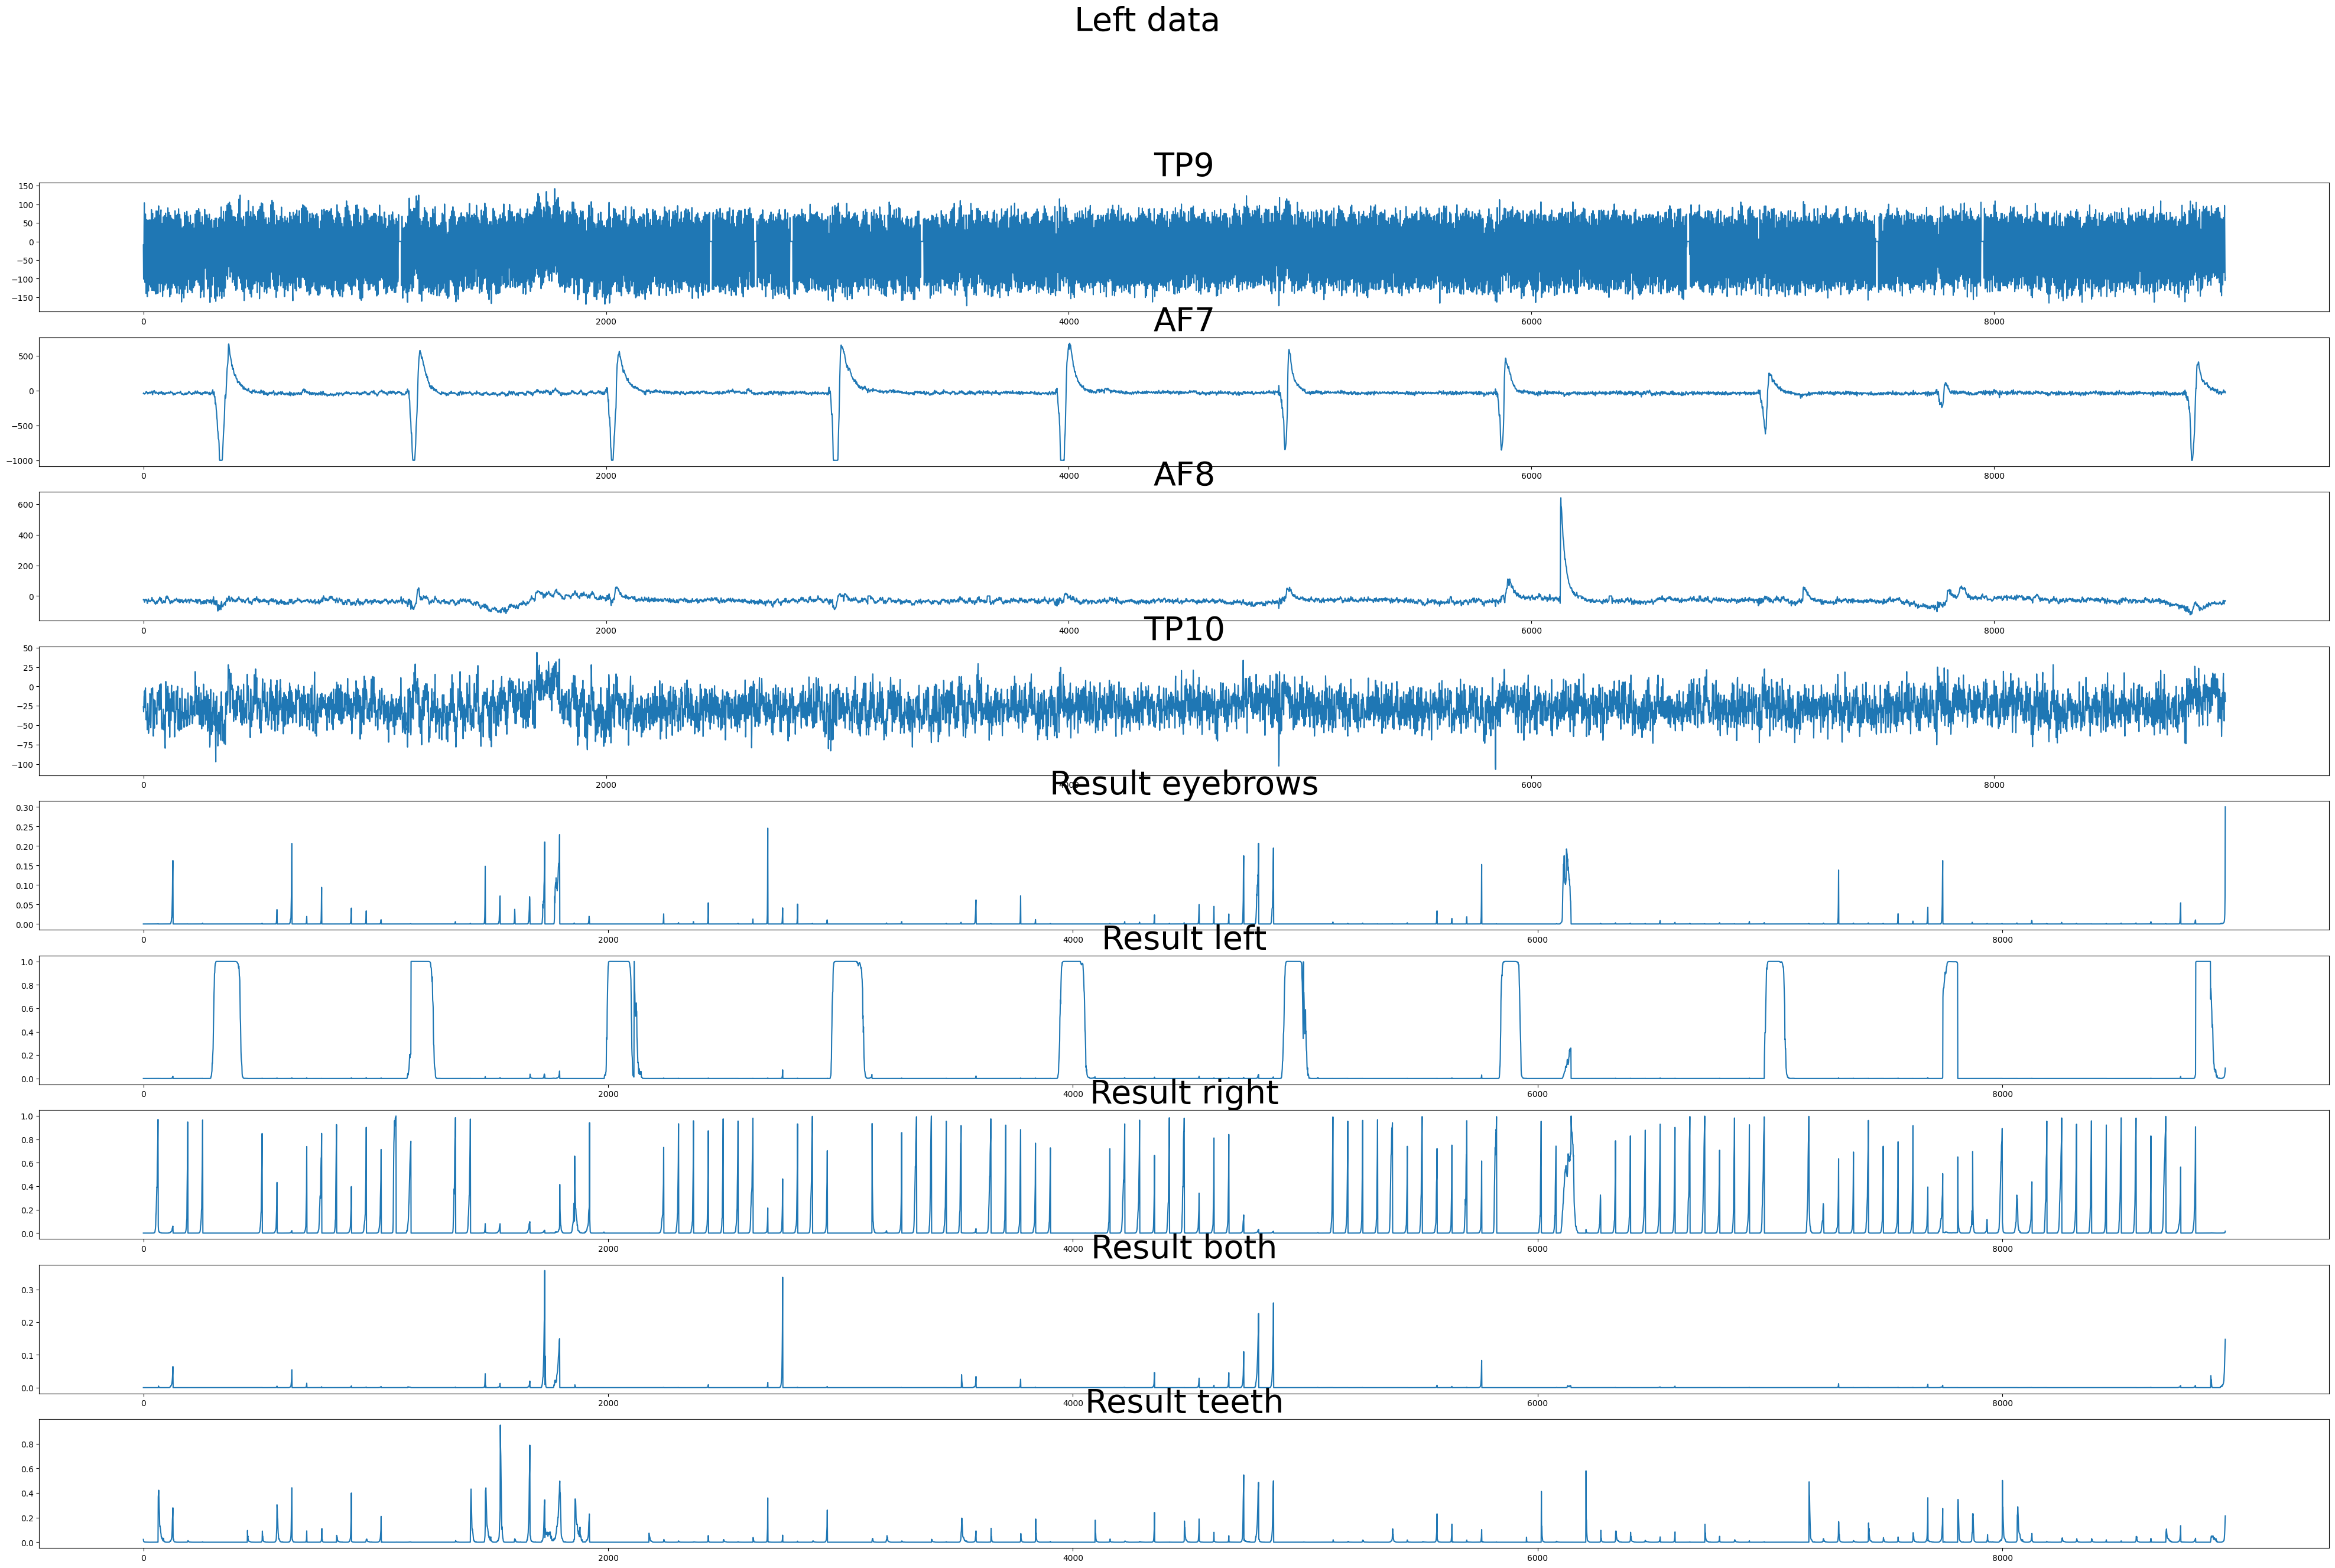

In [15]:
# Eyebrows inference dataset
data, input_data = get_input(df_left, time_step=64)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Left data")

(160, 20, 64, 1)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


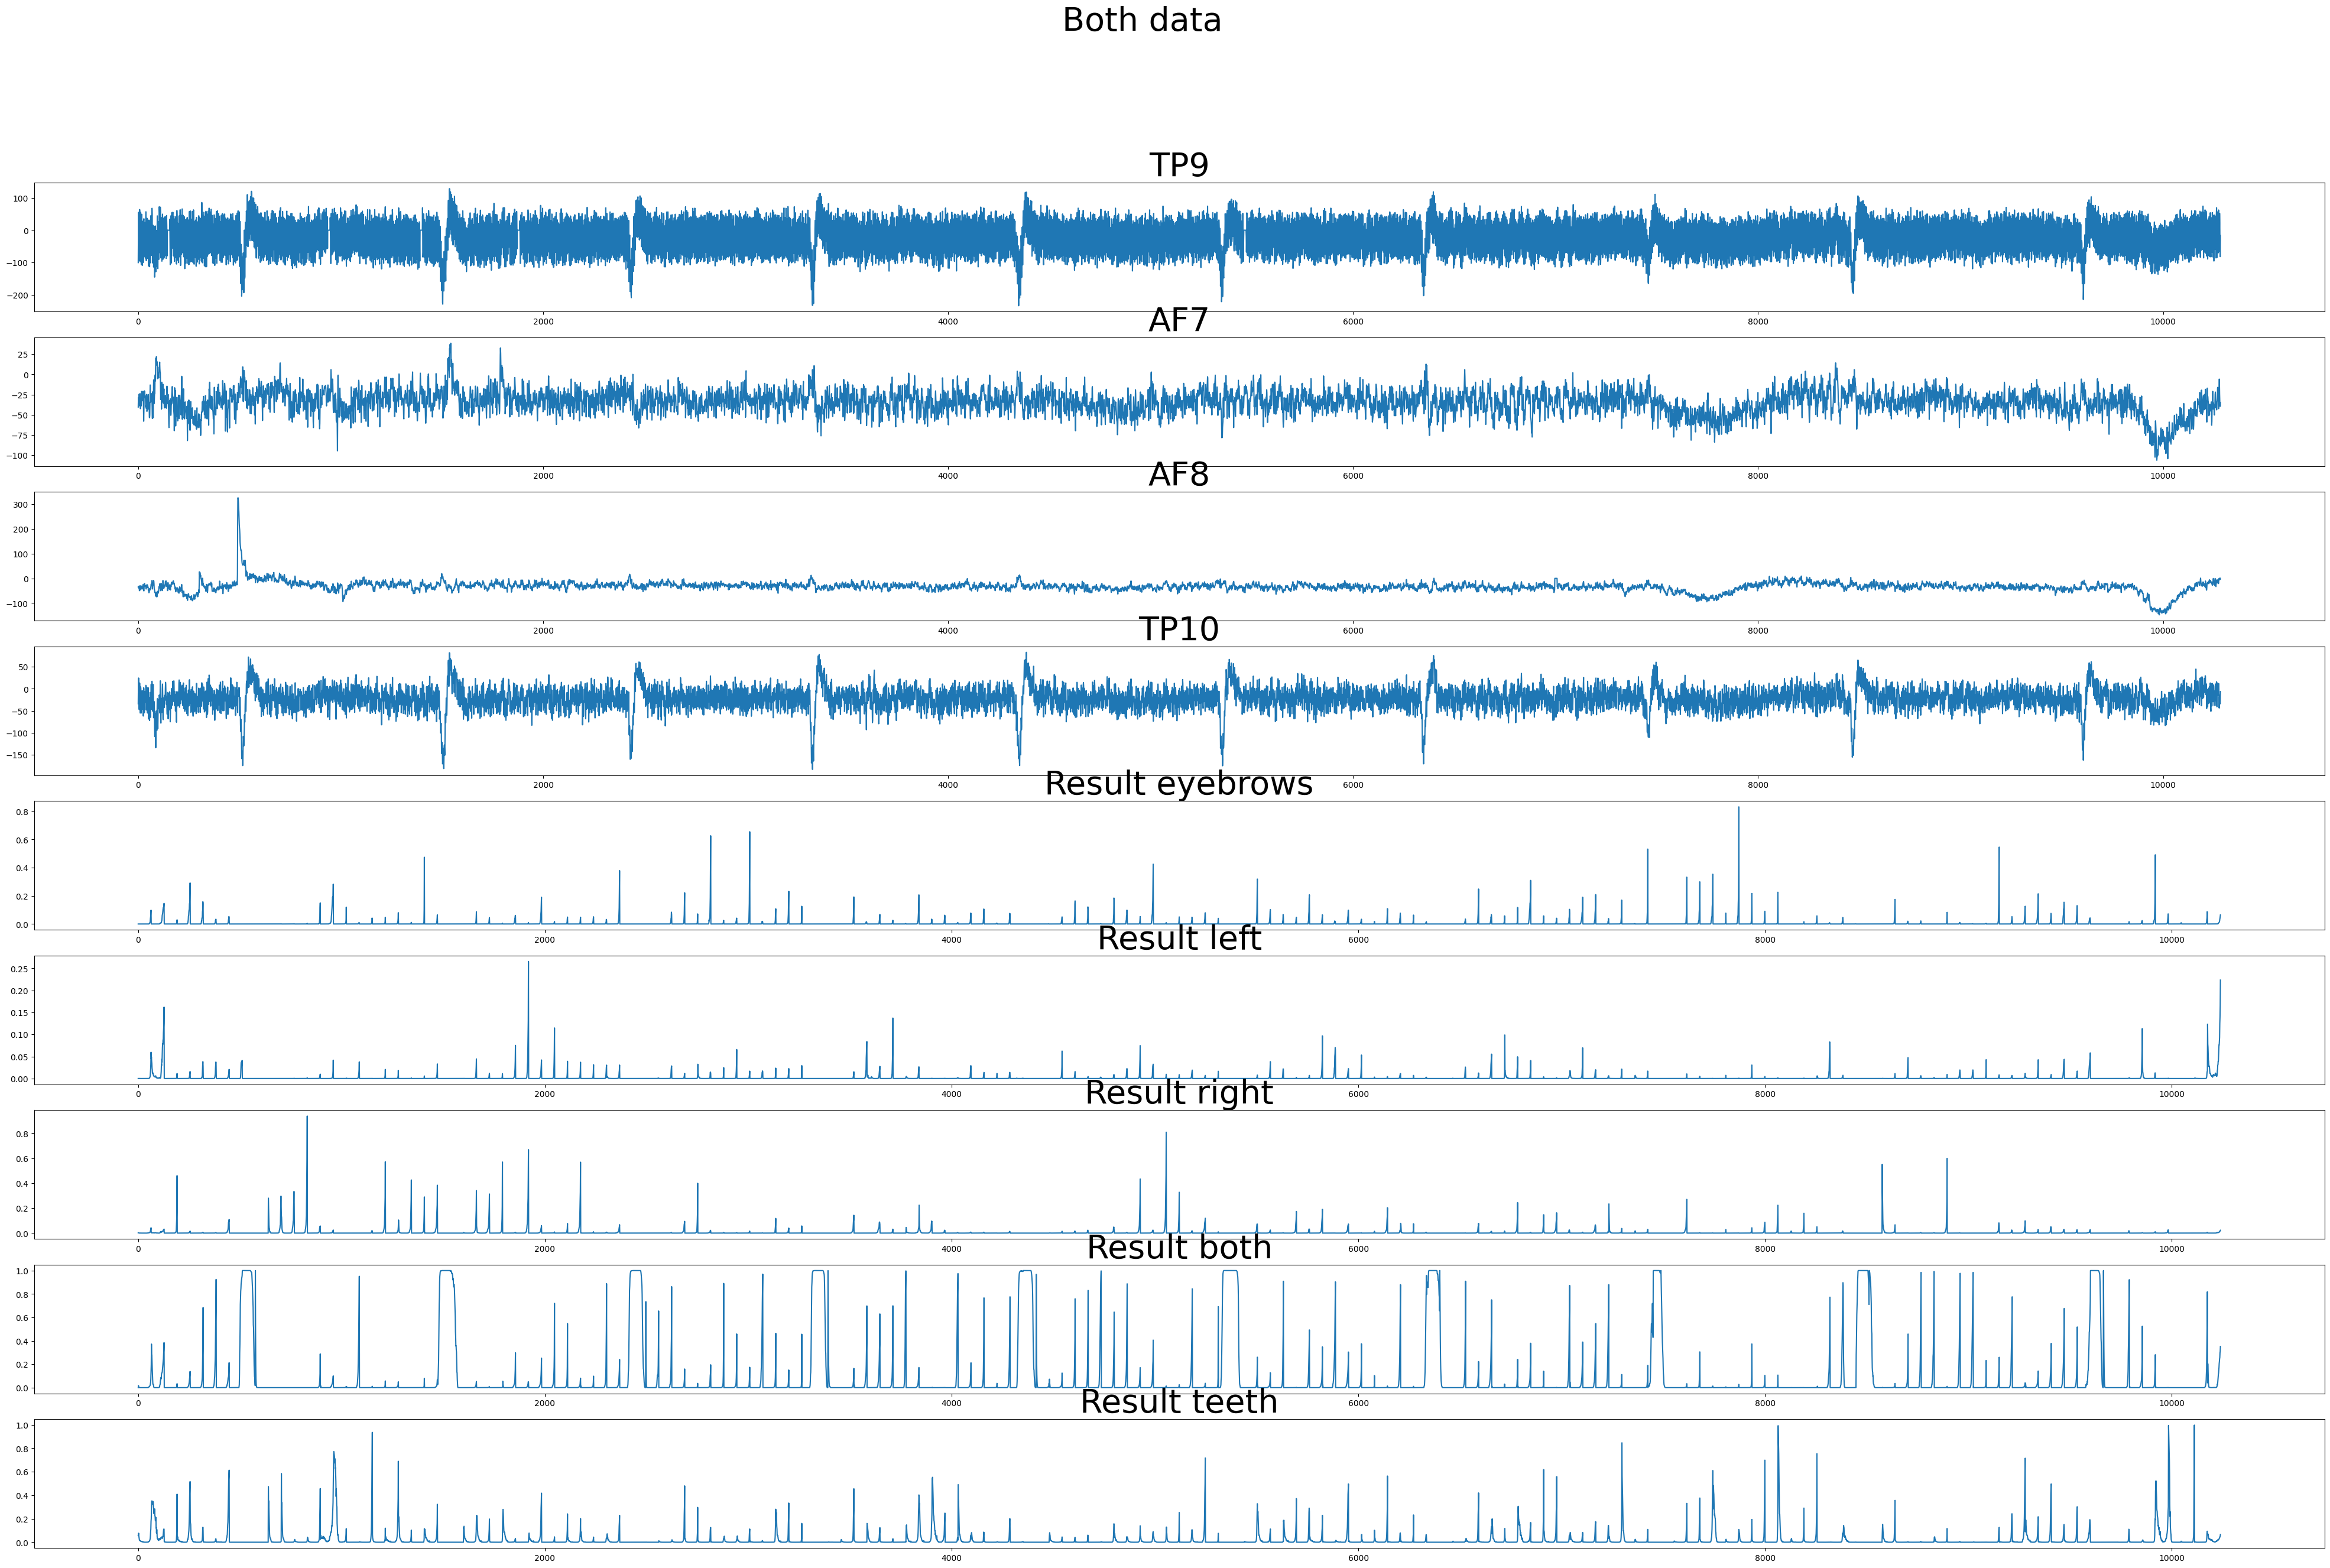

In [16]:
# Eyebrows inference dataset
data, input_data = get_input(df_both, time_step=64)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Both data")

(120, 20, 64, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


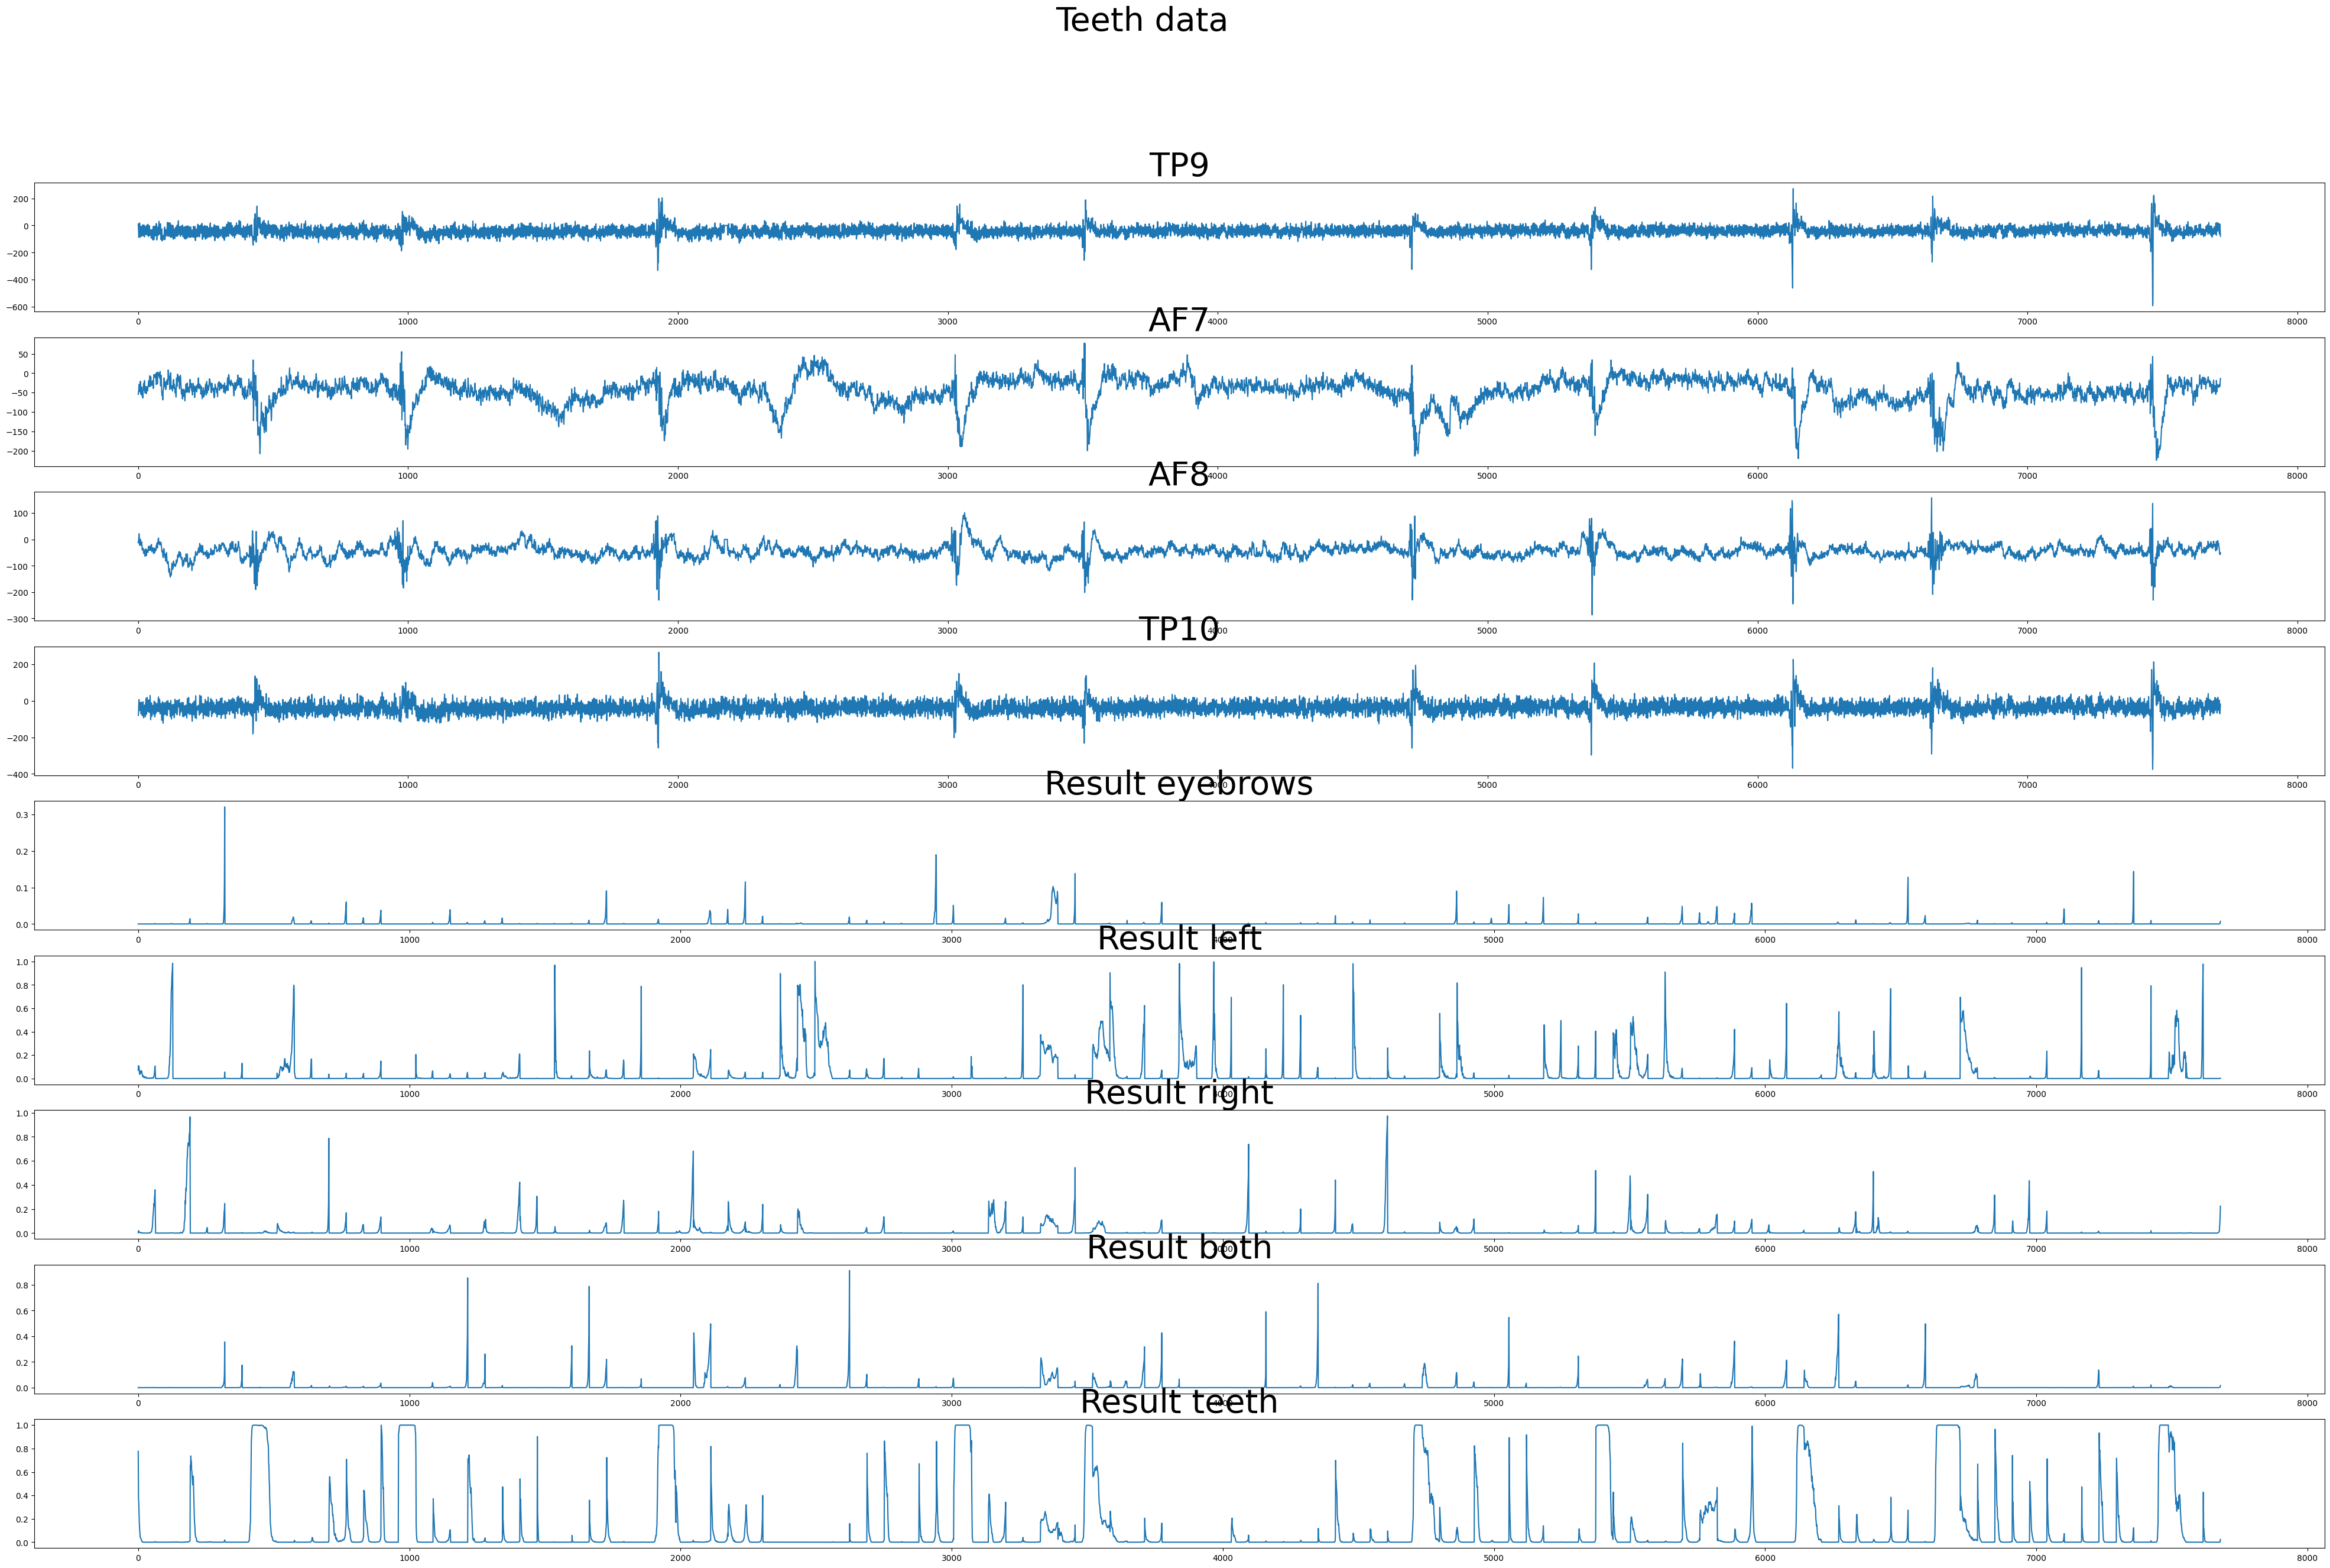

In [17]:
# Eyebrows inference dataset
data, input_data = get_input(df_teeth, time_step=64)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Teeth data")